### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from IPython.display import clear_output
from typing import List
import matplotlib.pyplot as plt

In [2]:
# !pip3 install transformers
# !python -m spacy download ru_core_news_md
# clear_output()

In [3]:
import pandas as pd
import numpy as np
import json
import torch

from sklearn.model_selection import train_test_split

sys.path.insert(0, "../")
from manipulation_helpers.data_preparation import ManipulationDataset, markup_conll, encode_tags, get_connections, Markup, read_markup

## Data processing

### .tsv -> markup

In [4]:
# Путь до разметки
PATH_TO_MARKUP = '../../data/assignments_from_pool_1115675__03-10-2022.tsv'
markup = read_markup(PATH_TO_MARKUP)
print("Всего разметок:", len(markup))

Всего разметок: 1883


In [5]:
markup["output_result"].iloc[0]

[{'class_name': 'Прием маскировки под ссылку на авторитет (деавторизация)',
  'text': 'Переговоры лидеров',
  'start': 0,
  'end': 19,
  'manipulation_target_id': 'no-entity',
  'manipulation_target_text': 'Сущность не названа в тексте'},
 {'class_name': 'Прием маскировки под ссылку на авторитет (деавторизация)',
  'text': 'Пекине - Лавров*',
  'start': 158,
  'end': 175,
  'manipulation_target_id': '5',
  'manipulation_target_text': '6. пекине-лавров'}]

In [6]:
markup["input_entitiesdata"].iloc[0]

[{'name': 'россия', 'from': 19, 'to': 25},
 {'name': 'китай', 'from': 28, 'to': 33},
 {'name': 'пекин', 'from': 56, 'to': 62},
 {'name': 'рф', 'from': 83, 'to': 85},
 {'name': 'кнр', 'from': 88, 'to': 91},
 {'name': 'пекине-лавров', 'from': 114, 'to': 129}]

In [7]:
markup.head(1)

,input_input,input_document_id,input_entitiesdata,output_result,output_document_id,output_text_review_mode,golden_result,golden_document_id,golden_text_review_mode,hint_text,hint_default_language,assignment_link,assignment_task_id,assignment_assignment_id,assignment_worker_id,assignment_status,assignment_started
0,Переговоры лидеров России и Китая состоятся 4 ...,05c3dbcf-e721-3609-b05a-dcd5b5d1e444,"[{'name': 'россия', 'from': 19, 'to': 25}, {'n...",[{'class_name': 'Прием маскировки под ссылку н...,05c3dbcf-e721-3609-b05a-dcd5b5d1e444,"{""class"":""text__selected""\,""textInputClasses"":...",NaN,NaN,NaN,NaN,NaN,https://sandbox.toloka.yandex.com/task/1115675...,c4b7444c-c5d8-4103-9e59-0aa545c2d230,000011061b--621dd95a614c2310d60d0973,58a52b1b5e173593bc52fbdfe9042122,APPROVED,2022-03-01T08:29:14.268


### markup -> list

Приводим данные к формату conll:

In [8]:
# пример работы фунции
index = 0
markup_conll(markup["input_input"].iloc[index], markup["output_result"].iloc[index], markup["input_entitiesdata"].iloc[index])

(['Переговоры',
  'лидеров',
  'России',
  'и',
  'Китая',
  'состоятся',
  '4',
  'февраля',
  'в',
  'Пекине',
  '.',
  'Переговоры',
  'лидеров',
  'РФ',
  'и',
  'КНР',
  'состоятся',
  '4',
  'февраля',
  'в',
  'Пекине',
  '-',
  'Лавров',
  '.'],
 [Markup(manipulation_class='B-Прием_маскировки_под_ссылку_на_авторитет', manipulation_target=0, entity_id=0),
  Markup(manipulation_class='I-Прием_маскировки_под_ссылку_на_авторитет', manipulation_target=0, entity_id=0),
  Markup(manipulation_class='O', manipulation_target=0, entity_id=1),
  Markup(manipulation_class='O', manipulation_target=0, entity_id=0),
  Markup(manipulation_class='O', manipulation_target=0, entity_id=2),
  Markup(manipulation_class='O', manipulation_target=0, entity_id=0),
  Markup(manipulation_class='O', manipulation_target=0, entity_id=0),
  Markup(manipulation_class='O', manipulation_target=0, entity_id=0),
  Markup(manipulation_class='O', manipulation_target=0, entity_id=0),
  Markup(manipulation_class='O', m

In [9]:
texts: List[str] = []
markups: List[List[Markup]] = []
for index, row in markup.iterrows():
    text, row_markup = markup_conll(row["input_input"], row["output_result"], row["input_entitiesdata"])

    texts.append(text)
    markups.append(row_markup)
clear_output()

In [10]:
unique_tags = {x.manipulation_class for m in markups for x in m}
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [11]:
train_texts, val_texts, train_markups, val_markups, train_ids, val_ids = train_test_split(texts, markups, range(len(texts)), test_size=.2, random_state=42)

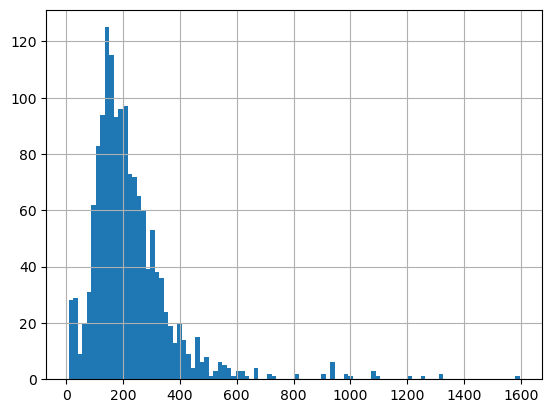

In [12]:
plt.hist(list(map(len, train_texts)), bins=100)
plt.grid()
plt.show()

### Dataset & tokenization

In [13]:
MODEL_NAME = "cointegrated/rubert-tiny2"

In [14]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)#, local_files_only=True)
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True, max_length=512)

In [15]:
train_labels = encode_tags(train_markups, train_encodings, "manipulation_class", tag2id=tag2id)
val_labels = encode_tags(val_markups, val_encodings, "manipulation_class", tag2id=tag2id)

train_entities = encode_tags(train_markups, train_encodings, "entity_id")
val_entities = encode_tags(val_markups, val_encodings, "entity_id")

train_manipulation_targets = encode_tags(train_markups, train_encodings, "manipulation_target")
val_manipulation_targets = encode_tags(val_markups, val_encodings, "manipulation_target")

In [16]:
train_connections, train_connections_ans = get_connections(train_entities, train_manipulation_targets)
val_connections, val_connections_ans = get_connections(val_entities, val_manipulation_targets)

In [17]:
len(train_encodings['input_ids']), len(train_labels)

(1506, 1506)

In [40]:
import torch
from torch.utils.data import DataLoader

train_dataset = ManipulationDataset(train_encodings, train_labels, train_connections, train_connections_ans)
val_dataset = ManipulationDataset(val_encodings, val_labels, val_connections, val_connections_ans)
train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)

In [41]:
input_ids, attention_mask, labels, connection_matrix = train_dataset[303]

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


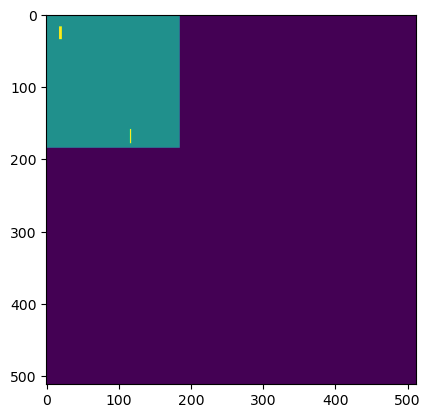

In [42]:
print(connections_ans)
plt.imshow(connection_matrix)

## Model pipeline

### Pytorch Model

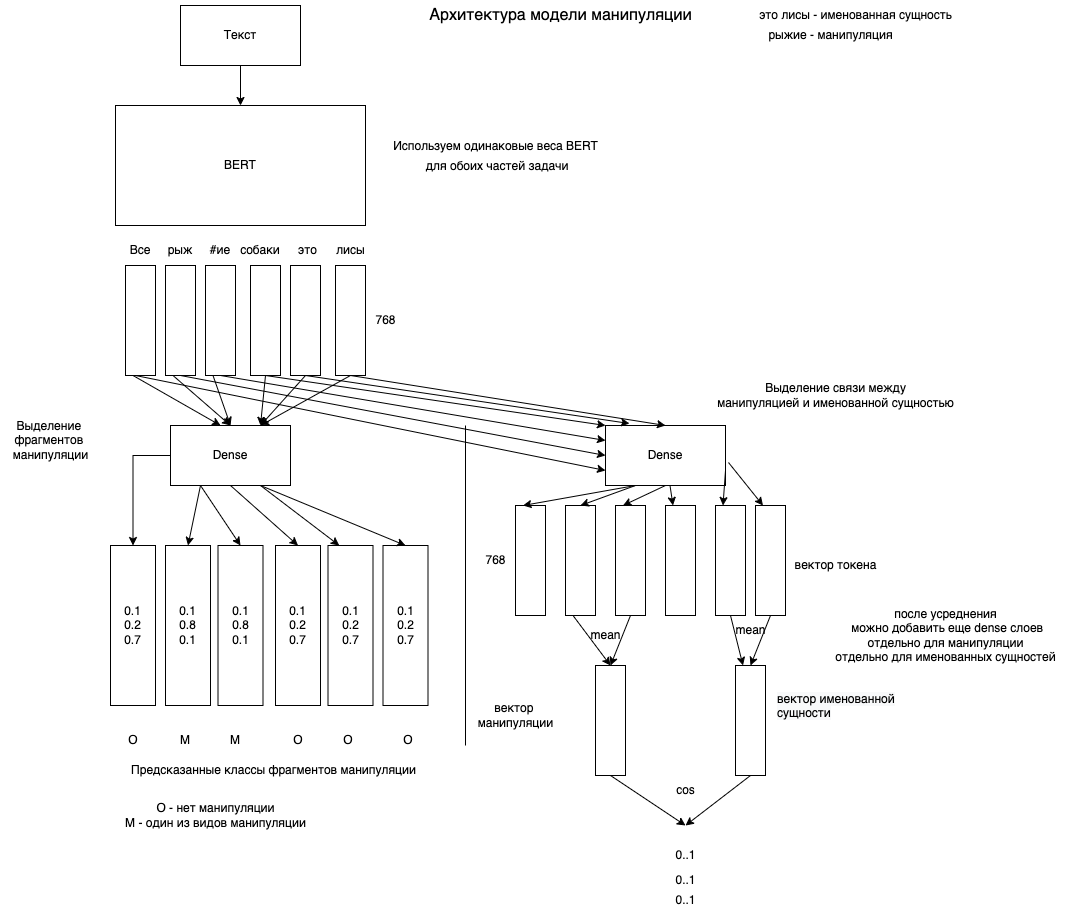

In [49]:
from torch import nn
from transformers import AutoModel
from manipulation_helpers.models import ComplexModel

### Training

In [50]:
model = ComplexModel(MODEL_NAME)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
from transformers import AdamW
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()
accumulation_steps = 1
empty_batches = []

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)
criterion_man = nn.CrossEntropyLoss(ignore_index=-100)
criterion_con = nn.CrossEntropyLoss(ignore_index=-1)

train_man_losses = []
train_con_losses = []

for epoch in range(1):
    epoch_man_loss = []
    epoch_con_loss = []
    for input_ids, attention_mask, labels, connections_matrix in tqdm(train_loader):
        optim.zero_grad()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        connections_matrix = connections_matrix.to(device)
        manipulation_output, connection_output = model(input_ids, attention_mask=attention_mask)
        loss1 = criterion_man(manipulation_output.reshape(-1, 37), labels.reshape(-1))
        loss2 = criterion_con(connection_output.reshape(-1), connections_matrix.reshape(-1))
        epoch_man_loss.append(loss1.item())
        epoch_con_loss.append(loss2.item())
        loss = loss1 + loss2 * 3
        loss.backward()
        optim.step()
    train_man_losses.append(np.mean(epoch_man_loss))
    train_con_losses.append(np.mean(epoch_con_loss))
    print(f"Epoch: {epoch}, Loss man: {train_man_losses[-1]}, Loss con: {train_con_losses[-1]}")

  8%|██████▊                                                                          | 16/189 [02:14<24:15,  8.41s/it]


KeyboardInterrupt: 

In [47]:
device

device(type='cuda')

### Evaluation

In [ ]:
model.eval()
val_predict = []
val_labels = []

with torch.no_grad():
    i = 0
    for input_ids, attention_mask, labels, connections, connections_ans in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        connections = connections
        labels = labels.to(device)
        logits, con_logits = model(
            input_ids=input_ids, 
            connections=connections, 
            attention_mask=attention_mask, 
            labels=labels)
        # labels = labels.view(-1).to('cpu')
        y_hats = logits.argmax(-1)
        # val_predict.extend([x for x in y_hats[0]])
        val_labels += labels.cpu().numpy().tolist()
        val_predict += y_hats.cpu().numpy().tolist()

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("seqeval")

def compute_metrics(predictions, labels):
    # Remove ignored index (special tokens)
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
compute_metrics(val_predict, val_labels)